## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
print('Please be honest with yourself.')
is_kia_running = True if input('Are you Kiarash Vaziri Goodarzi? ')[0] in ['y', 'Y'] else False
is_zahra_running = False if is_kia_running else True if input('Are you Zahra Sodagar? ')[0] in ['y', 'Y'] else False
is_radmehr_running = False if is_kia_running or is_zahra_running else True if input('Are you Radmehr Karimian? ')[0] in ['y', 'Y'] else False
zahra_root = '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/'
kia_root = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/DL_Project'
radmehr_root = '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/'
project_root = kia_root if is_kia_running else zahra_root if is_zahra_running else radmehr_root if is_radmehr_running else '/content'

Please be honest with yourself.
Are you Kiarash Vaziri Goodarzi? No.
Are you Zahra Sodagar? Yes!


In [ ]:
! pip -q install --upgrade --no-cache-dir gdown

In [ ]:
import os
import shutil

for fname in ['MSCTD', 'train_ende.zip', 'test.zip']:
  if not fname in os.listdir():
    if not fname in os.listdir(project_root):
      if fname == 'train_ende.zip':
        ! gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
      elif fname == 'test.zip':
        ! gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
      elif fname == 'MSCTD': 
        ! git clone https://github.com/XL2248/MSCTD
    else:
      if fname == 'MSCTD':
        ! git clone https://github.com/XL2248/MSCTD
      else:
        shutil.copy2(os.path.join(project_root, fname), fname)
    if fname in os.listdir():
      if not fname in os.listdir(project_root): 
        if fname == 'MSCTD': 
          shutil.copytree(fname, os.path.join(project_root, fname))
        else: 
          shutil.copy2(fname, os.path.join(project_root, fname))
      print(f'{fname} was added successfully.')
    else:
      print(f'Failed to add {fname}.')

! cp MSCTD/MSCTD_data/ende/english_*.txt .
! cp MSCTD/MSCTD_data/ende/image_index_*.txt .
! cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
MSCTD was added successfully.
train_ende.zip was added successfully.
test.zip was added successfully.


In [ ]:
%%bash
for x in *.zip 
do 
  unzip -qq $x
done;

In [ ]:
! ls train_ende | head 

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg


In [ ]:
! head english_train.txt

Okay. I'm confused.
You don't care if I go to Paris with Jane,
I'm sorry. I have to tell you something,
I have to go.
I'm an accessory to murder.
I think you've helped enough.
Gaby, please. I can't stand this anymore.
Can't we talk for a minute?
To be honest,
Wait. What do you mean?


In [ ]:
! head sentiment_train.txt

0
0
1
1
1
2
1
1
0
1


In [ ]:
! head image_index_train.txt

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16]
[17, 18, 19, 20, 21]
[22, 23, 24, 25, 26]
[27, 28, 29, 30, 31]
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[43, 44, 45, 46, 47, 48, 49, 50, 51]
[52, 53, 54, 55, 56, 57]
[58, 59, 60, 61, 62]


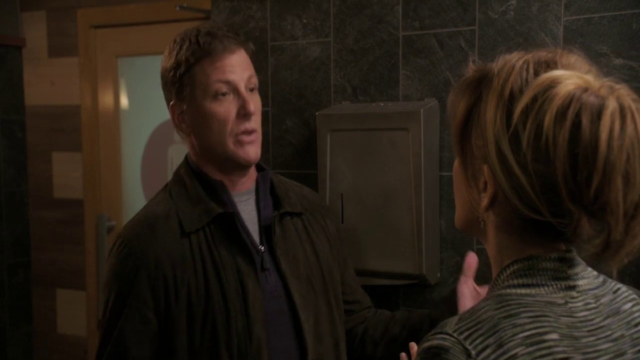

In [ ]:
from PIL import Image
from IPython import display
import os

img = Image.open(os.path.join("train_ende","0.jpg"))
d = display.display(img.resize((640, 360), Image.BILINEAR), display_id=True)

## MSCTDataset Dataloader classes


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import ast

In [ ]:
train_dirs = {'image':'/content/train_ende', 'sentence':'/content/english_train.txt', \
              'dialogue':'/content/image_index_train.txt', 'sentiment':'/content/sentiment_train.txt'}
test_dirs = {'image':'/content/test', 'sentence':'/content/english_test.txt', \
              'dialogue':'/content/image_index_test.txt', 'sentiment':'/content/sentiment_test.txt'}

In [ ]:
class MSCTDataset(Dataset):
    def __init__(self, dirs_dict, include_images=True, include_sentences=True, \
                 include_dialogues=True, include_index=False, pack_dialogues=False,\
                 image_transform=None, sentence_transform=None, sentiment_transform=None):
        assert include_images or include_sentences, 'you should indicate at least one domain for the dataset.'
        assert isinstance(dirs_dict, dict)
        assert dirs_dict['sentiment']
        
        self.sentiment_dir = dirs_dict['sentiment']
        self.sentiments = read_txt(self.sentiment_dir, int)
        self.include_images = include_images
        self.include_sentences = include_sentences
        self.include_dialogues = include_dialogues
        self.include_index = include_index
        self.pack_dialogues = pack_dialogues
        self.image_transform = image_transform
        self.sentence_transform = sentence_transform
        self.sentiment_transform = sentiment_transform

        if include_images:
            assert dirs_dict['image']
            self.image_dir = dirs_dict['image']
        if include_sentences:
            assert dirs_dict['sentence']
            self.sentence_dir = dirs_dict['sentence']
            self.sentences = read_txt(self.sentence_dir)
        if include_dialogues or pack_dialogues:
            assert dirs_dict['dialogue']
            self.dialogue_dir = dirs_dict['dialogue']
            self.dialogues = read_txt(self.dialogue_dir, ast.literal_eval)

    def __len__(self):
        if self.pack_dialogues:
          return len(self.dialogues)
        else:
          return len(self.sentiments)

    def __getoneitem__(self, idx):
        outputs = list()
        if self.include_index:
          outputs.append(idx)
        if self.include_images:
          img_path = os.path.join(self.image_dir, str(idx) + '.jpg')
          image = Image.open(img_path) # read_image(img_path)
          if self.image_transform:
            image = self.image_transform(image)
          outputs.append(image)

        if self.include_sentences:
          sentence = self.sentences[idx]
          if self.sentence_transform:
            sentence = self.sentence_transform(sentence)
          outputs.append(sentence)

        if self.include_dialogues:
          for dialogue in self.dialogues:
            if idx in dialogue:
              break
          outputs.append(dialogue)
        
        sentiment = self.sentiments[idx]
        if self.sentiment_transform:
          sentiment = self.sentiment_transform(sentiment)
        outputs.append(sentiment)
        return outputs

    def __getitem__(self, idx):
      if self.pack_dialogues:
        indices = self.dialogues[idx]
        outputs = [self.__getoneitem__(i) for i in indices]
        final_output = [[outputs[i][j] for i in range(len(outputs))] for j in range(len(outputs[0]))]
        return final_output
      else:
        return self.__getoneitem__(idx)

      
def read_txt(path, line_transform=None):
    ls = list()
    with open(path, 'r') as f:
        for line in f:
            if line_transform:
              line = line_transform(line)
            else:
              if line[-1:] == '\n':
                line = line[:-1]
            ls.append(line)
    return ls


#### Dataset with pack_dialogues=False and image type as tensor:

In [ ]:
train_data = MSCTDataset(train_dirs, pack_dialogues=False, image_transform=ToTensor())
test_data = MSCTDataset(test_dirs, pack_dialogues=False, image_transform=ToTensor())

print(f'Number of samples in the training dataset is {len(train_data)}. \nNumber of samples in the testing dataset is {len(test_data)}.')

Number of samples in the training dataset is 20240. 
Number of samples in the testing dataset is 5067.


In [ ]:
sample = train_data[500]
sample

[tensor([[[0.4000, 0.4000, 0.4000,  ..., 0.0824, 0.0824, 0.0824],
          [0.4039, 0.4039, 0.4039,  ..., 0.0824, 0.0824, 0.0824],
          [0.4039, 0.4039, 0.4039,  ..., 0.0824, 0.0824, 0.0824],
          ...,
          [0.0510, 0.0392, 0.0275,  ..., 0.2627, 0.2627, 0.2706],
          [0.0471, 0.0353, 0.0235,  ..., 0.2627, 0.2588, 0.2667],
          [0.0392, 0.0314, 0.0196,  ..., 0.2549, 0.2549, 0.2627]],
 
         [[0.4471, 0.4471, 0.4471,  ..., 0.0706, 0.0706, 0.0706],
          [0.4510, 0.4510, 0.4510,  ..., 0.0706, 0.0706, 0.0706],
          [0.4510, 0.4510, 0.4510,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.0471, 0.0353, 0.0235,  ..., 0.2353, 0.2353, 0.2431],
          [0.0431, 0.0314, 0.0196,  ..., 0.2353, 0.2314, 0.2392],
          [0.0353, 0.0275, 0.0157,  ..., 0.2275, 0.2275, 0.2353]],
 
         [[0.5020, 0.5020, 0.5020,  ..., 0.0431, 0.0431, 0.0431],
          [0.5059, 0.5059, 0.5059,  ..., 0.0431, 0.0431, 0.0431],
          [0.4980, 0.4980, 0.4980,  ...,

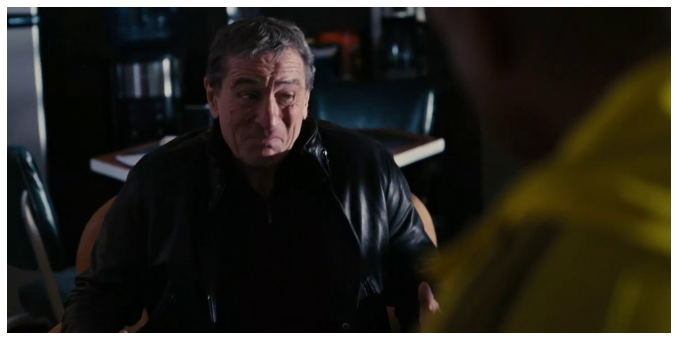

In [ ]:
image, sentence, dialogue, sentiment = sample
plt.figure(figsize=(16, 6))
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Dataset with pack_dialogues=True and image type as PIL image:

In [ ]:
train_data = MSCTDataset(train_dirs, pack_dialogues=True, include_dialogues=False)
test_data = MSCTDataset(test_dirs, pack_dialogues=True, include_dialogues=False)

print(f'Number of samples in the training dataset is {len(train_data)}. \nNumber of samples in the testing dataset is {len(test_data)}.')

Number of samples in the training dataset is 2066. 
Number of samples in the testing dataset is 509.


In [ ]:
sample = train_data[500]
sample

[[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x946 at 0x7FB8786457C0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x948 at 0x7FB8786457F0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x946 at 0x7FB878645D00>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x947 at 0x7FB878F28340>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x946 at 0x7FB878F28CA0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x948 at 0x7FB878F28670>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x947 at 0x7FB878D112B0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x947 at 0x7FB878D11AF0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x948 at 0x7FB878D11F10>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x948 at 0x7FB878D11D60>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x947 at 0x7FB87B6AF9A0>],
 ["You couldn't even get a bank account without Dad's

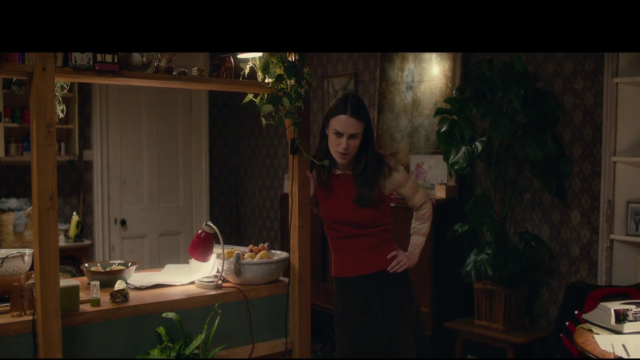

In [ ]:
image, sentence, sentiment = sample
img = image[0]
d = display.display(img.resize((640, 360), Image.BILINEAR), display_id=True)

## Dataset statistics


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_data = MSCTDataset(train_dirs, pack_dialogues=False, image_transform=ToTensor())
test_data = MSCTDataset(test_dirs, pack_dialogues=False, image_transform=ToTensor())

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=True)

#### Distribution of sentiments

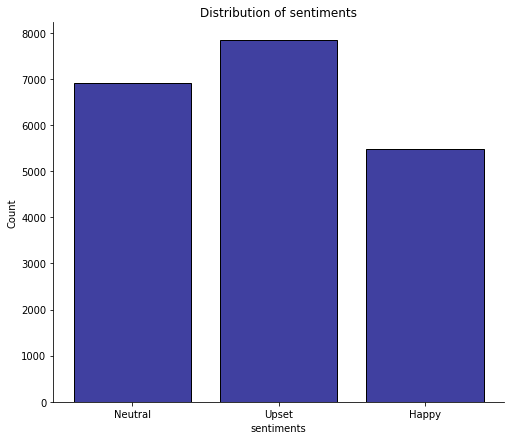

In [ ]:
dict_emotions = {0:'Neutral', 1:'Upset', 2:'Happy'}
emotions = list(map(lambda x:dict_emotions[x], train_data.sentiments))
df_emotions = pd.DataFrame(emotions, columns=['sentiments'])

sns.displot(data=df_emotions,
            x='sentiments',
            color='navy',
            shrink=0.8,       
            height=6,      
            aspect=1.2  
            ).set(title=f'Distribution of sentiments')
plt.show()

In [ ]:
(np.array(train_data.sentiments) == 2).sum()

5483

In [ ]:
train_dist = torch.tensor([6922, 7835, 5483])
(train_dist / train_dist.sum())

tensor([0.3420, 0.3871, 0.2709])

#### Statistics of length of sentences

Average number of words in a sentence: 6.46
Variance of number of words in a sentence: 9.25



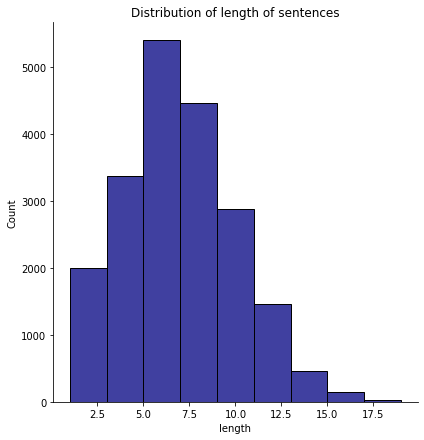

In [ ]:
sentences = train_data.sentences
len_sentences = np.array([len(s.split(' ')) for s in sentences])
print(f"Average number of words in a sentence: {len_sentences.mean():.2f}\nVariance of number of words in a sentence: {len_sentences.var():.2f}\n")

df_len = pd.DataFrame(len_sentences, columns=['length'])
sns.displot(df_len,
            x='length',
            bins=9,
            color='navy',
            height=6, 
            aspect=1
            ).set(title=f'Distribution of length of sentences')
plt.show()

In [ ]:
n = 25
for s, l in zip(sentences[:n], len_sentences[:n]):
  print(f"{l:2.0f} word(s): {s}")

 3 word(s): Okay. I'm confused.
10 word(s): You don't care if I go to Paris with Jane,
 8 word(s): I'm sorry. I have to tell you something,
 4 word(s): I have to go.
 5 word(s): I'm an accessory to murder.
 5 word(s): I think you've helped enough.
 7 word(s): Gaby, please. I can't stand this anymore.
 6 word(s): Can't we talk for a minute?
 3 word(s): To be honest,
 5 word(s): Wait. What do you mean?
13 word(s): He called us down to the station and grilled US one by one.
 7 word(s): Why didn't he call me down there?
 9 word(s): Good question, given this whole thing is about you.
 5 word(s): What are you talking about?
10 word(s): Bree, he wants revenge. He wants to bring you down,
 2 word(s): Gaby, please.
10 word(s): I will figure out a way to make things better.
 2 word(s): don't talk.
 6 word(s): Oh, my God! You brought it.
 7 word(s): Now before I give it to you..
 5 word(s): oh, well, that never works.
 6 word(s): What I was going to say..
 8 word(s): They're my whole world. I hav

#### Statistics of number of images/sentences per dialogues

Average number of images/sentences in a dialogue: 9.80
Variance of number of images/sentences in a dialogue: 17.70



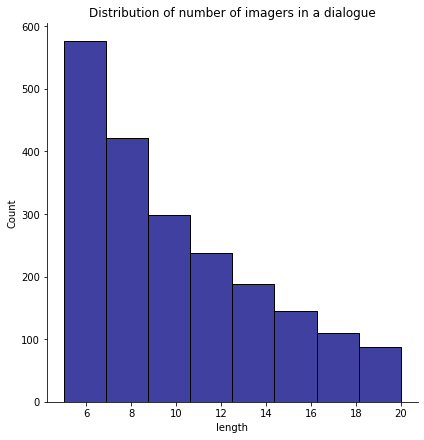

In [ ]:
dialogues = train_data.dialogues
len_dialogues = np.array([len(d) for d in dialogues])
print(f"Average number of images/sentences in a dialogue: {len_dialogues.mean():.2f}\nVariance of number of images/sentences in a dialogue: {len_dialogues.var():.2f}\n")

df_len = pd.DataFrame(len_dialogues, columns=['length'])
sns.displot(df_len,
            x='length',
            bins=8,
            color='navy',
            height=6, 
            aspect=1
            ).set(title=f'Distribution of number of imagers in a dialogue')
plt.show()

#### Statistics of number of present faces in an image

In [ ]:
! pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import cv2
from PIL import Image, ImageDraw
from IPython import display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)

train_data = MSCTDataset(train_dirs, pack_dialogues=False)
test_data = MSCTDataset(test_dirs, pack_dialogues=False)

Number of detected faces: 2



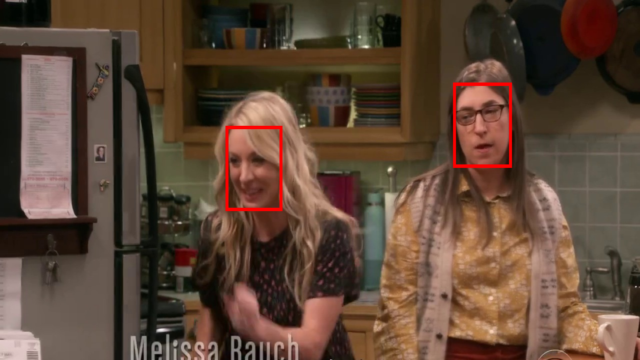

In [ ]:
frame, sentence, dialogue, sentiment = train_data[6568]
boxes, face_logits = mtcnn.detect(frame)
frame_draw = frame.copy()
if boxes is not None:
  
  draw = ImageDraw.Draw(frame_draw)
  print(f"Number of detected faces: {len(face_logits)}\n")
  for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
else:
  print(f"Number of detected faces: 0\n")

d = display.display(frame_draw.resize((640, 360), Image.BILINEAR), display_id=True)

In [ ]:
from tqdm import tqdm

n_faces = list()
for frame, sentence, dialogue, sentiment in tqdm(train_data):
  boxes, _ = mtcnn.detect(frame)
  if boxes is None:
    n_faces.append(0)
  else:
    n_faces.append(boxes.shape[0])

In [ ]:
n_faces_freq = np.array([n_faces.count(i) for i in range(max(n_faces)+1)])
print(f"Average number of faces in an image: {np.mean(n_faces):.2f}\nMedian of number of faces in an image: {np.median(n_faces):.2f}\nVariance of number of faces in an image: {np.var(n_faces):.2f}")

Average number of faces in an image: 1.54
Median of number of faces in an image: 1.00
Variance of number of faces in an image: 4.27


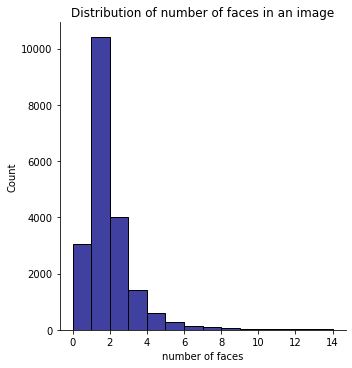

In [ ]:
df_faces = pd.DataFrame(n_faces, columns=['number of faces'])
sns.displot(df_faces[df_faces['number of faces']<15],
            x='number of faces',
            bins=14,
            color='navy',
            height=5, 
            aspect=1
            ).set(title=f'Distribution of number of faces in an image')
plt.show()

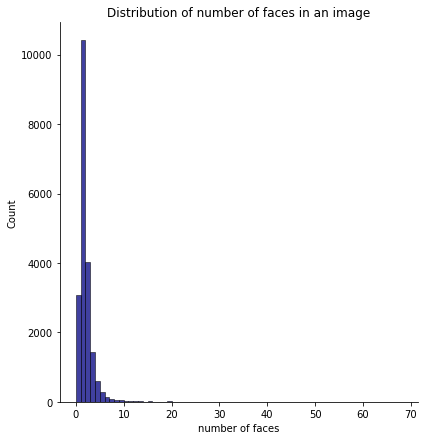

In [ ]:
df_faces = pd.DataFrame(n_faces, columns=['number of faces'])
sns.displot(df_faces,
            x='number of faces',
            bins=max(n_faces),
            color='navy',
            height=6, 
            aspect=1
            ).set(title=f'Distribution of number of faces in an image')
plt.show()

#### Correlation of number of words and the emotions

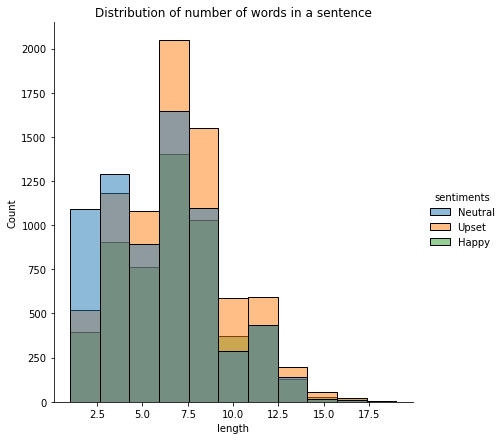

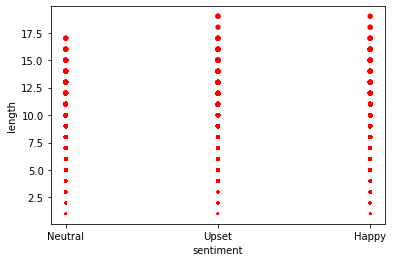

,length,sentiments
0,3,Neutral
1,10,Neutral
2,8,Upset
3,4,Upset
4,5,Upset
...,...,...
20235,5,Happy
20236,10,Neutral
20237,10,Neutral
20238,8,Happy


In [ ]:
df_len = pd.DataFrame(len_sentences, columns=['length'])
df_len_emotions = pd.concat([df_len, df_emotions], axis=1)
sns.displot(df_len_emotions,
            x='length',
            hue='sentiments',
            bins=11,
            color='navy',
            height=6, 
            aspect=1
            ).set(title=f'Distribution of number of words in a sentence')

plt.show()

sentences = train_data.sentences
dict_emotions = {0:'Neutral', 1:'Upset', 2:'Happy'}
emotions = list(map(lambda x:dict_emotions[x], train_data.sentiments))
len_sentences = np.array([len(s.split(' ')) for s in sentences])
df = pd.DataFrame(columns=['length', 'sentiment'])
df['length'] = len_sentences
df['sentiment'] = emotions
df.plot.scatter(x='sentiment', y='length', s='length', c='red')
plt.show()

df_len_emotions

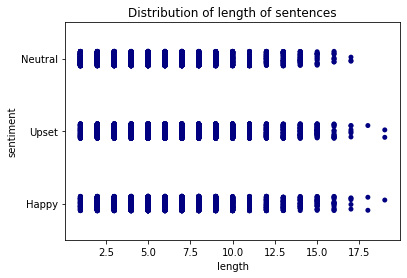

In [ ]:
sns.stripplot(data=df,
              x='length',
              y='sentiment',
              color='navy'
              ).set(title=f'Distribution of length of sentences')
plt.show()

#### Distribution of emotion patterns



In [ ]:
def compress_pattern(pattern):
    assert len(pattern) > 0
    ls = [pattern[0]]
    for d in pattern[1:]:
      if d != ls[-1]:
        ls.append(d)
    return ls

train_data = MSCTDataset(train_dirs, pack_dialogues=True, include_dialogues=False)
test_data = MSCTDataset(test_dirs, pack_dialogues=True, include_dialogues=False)

In [ ]:
dict_patterns = dict()

for sample in train_data:
  _, _, sentiments = sample
  pattern = compress_pattern(sentiments)
  pattern = str(pattern)
  if pattern in dict_patterns.keys():
    dict_patterns[pattern] += 1
  else:
    dict_patterns[pattern] = 1

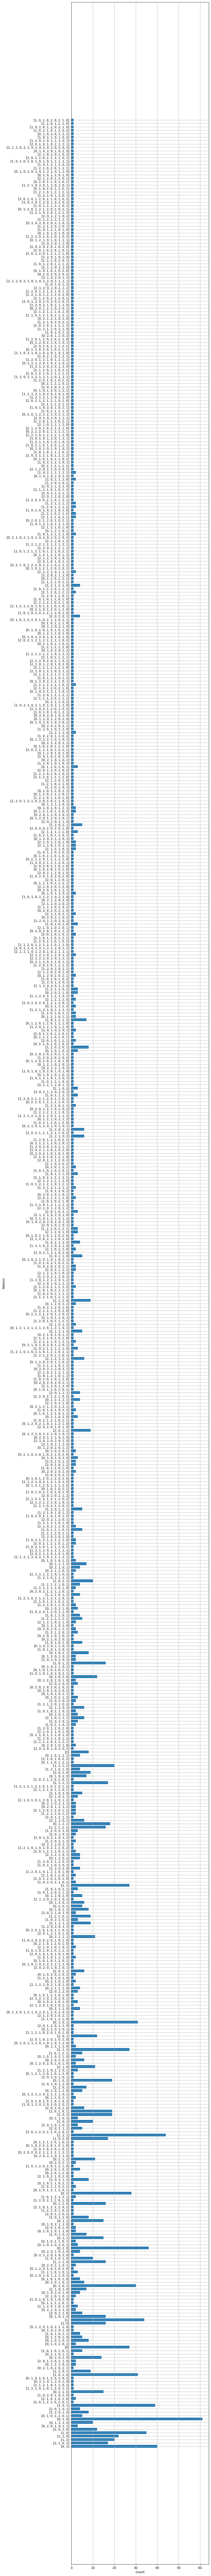

In [ ]:
ind = np.arange(len(dict_patterns))
plt.figure(figsize=(8, 150))
plt.barh(ind, list(dict_patterns.values()))
plt.yticks(ind, list(dict_patterns.keys()))
plt.ylabel('Pattern')
plt.xlabel('Count')
plt.grid()
plt.show()

#### Comparing number of compressed emotion pattern with the expected value
For an average number of sentences in a dialogue n, we can calculate the expected number of compressed emotion patterns using the following formula:

$n\ of\ compressed\ patterns = ∑_{i=1}^n 3\times2^{i-1}$

$n\ of\ uncompressed\ patterns = 3^n$

In [ ]:
n_patterns = len(dict_patterns)
dialogues = train_data.dialogues
dialogue_length_mean = np.round(np.array([len(d) for d in dialogues]).mean())
average_n_patterns = 3 * sum([2**i for i in range(int(dialogue_length_mean))])
print(f'Average of number of sentences in a dialogue: {int(dialogue_length_mean)}')
print(f'Expected number of compressed emotion patterns: {average_n_patterns}')
print(f'Actual number of compressed emotion patterns: {n_patterns}')

Average of number of sentences in a dialogue: 10
Expected number of compressed emotion patterns: 3069
Actual number of compressed emotion patterns: 681
